## Mixed-States Reconstruction

The partial coherence of the illumination probe in experimentally-obtained ptychographic datasets can often reduce the signal-to-noise of the reconstruction. To account for this we can use a [mixed-states PIE](https://doi.org/10.1038/s41467-020-16688-6) algorithm to decompose the probe wavefunction into a mixed quantum state.

We will use the same (thin) slab of [110] STO as our electrostatic potential:

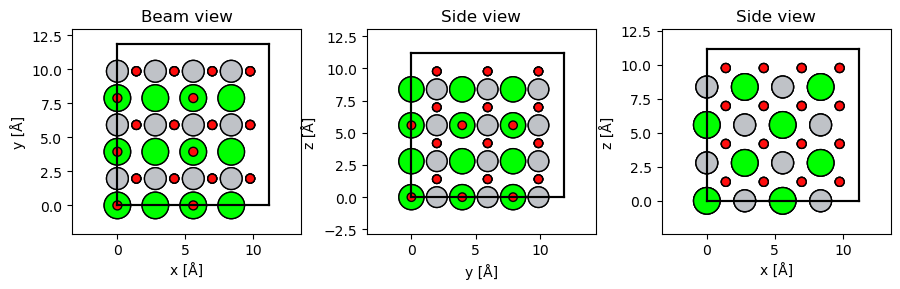

In [1]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell = read("../data/SrTiO3.cif")
STO_atoms = surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)

from abtem import show_atoms

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

show_atoms(STO_atoms, ax=ax1, title="Beam view")
show_atoms(STO_atoms, ax=ax2, plane="yz", title="Side view")
show_atoms(STO_atoms, ax=ax3, plane="xz", title="Side view")

fig.tight_layout();

In [2]:
from abtem import FrozenPhonons, Potential
from abtem import CTF, Probe

electrostatic_potential = Potential(
    STO_atoms,
    sampling=0.02,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
).build()

In order to simulate an example to test our algorithm, we implement a custom `CTF` function to separate our probe into radial bins (in reciprocal space):

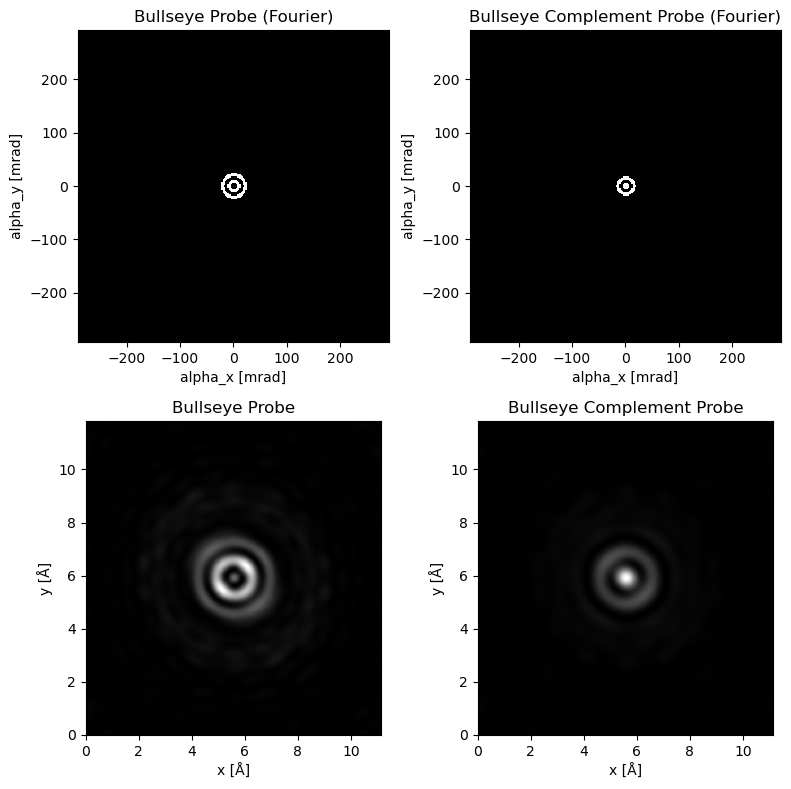

In [3]:
import numpy as np
from abtem import CTF, Probe
from abtem.device import get_array_module
from typing import Mapping


class Bullseye_CTF(CTF):
    def __init__(
        self,
        num_bars,
        complementary: bool = False,
        semiangle_cutoff: float = np.inf,
        energy: float = None,
        parameters: Mapping[str, float] = None,
    ):

        self._complementary = complementary
        self._num_bars = num_bars
        super().__init__(
            semiangle_cutoff=semiangle_cutoff,
            rolloff=0.0,
            energy=energy,
            parameters=parameters,
        )

    def evaluate(self, alpha, phi):

        array = self.evaluate_aberrations(alpha, phi)
        array *= self.evaluate_aperture(alpha, phi)

        xp = get_array_module(array)
        alpha = xp.array(alpha) * 1000.0

        if self._complementary:
            array *= (
                xp.sin(2 * np.pi * alpha * self._num_bars / self.semiangle_cutoff)
                >= 0.0
            )
        else:
            array *= (
                xp.sin(2 * np.pi * alpha * self._num_bars / self.semiangle_cutoff) < 0.0
            )

        return array


bullseye_ctf = Bullseye_CTF(
    2,
    semiangle_cutoff=24,
    energy=200e3,
    parameters={"C10": -75, "C12": 10, "phi12": 0.785},
)

bullseye_complent_ctf = Bullseye_CTF(
    2,
    complementary=True,
    semiangle_cutoff=24,
    energy=200e3,
    parameters={"C10": -75, "C12": 10, "phi12": 0.785},
)

bullseye_probe = Probe(energy=200e3, ctf=bullseye_ctf, device="gpu")
bullseye_probe.match_grid(electrostatic_potential)
bullseye_complent_probe = Probe(energy=200e3, ctf=bullseye_complent_ctf, device="gpu")
bullseye_complent_probe.match_grid(electrostatic_potential)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

bullseye_probe.build().diffraction_pattern().show(
    ax=ax1, title="Bullseye Probe (Fourier)"
)
bullseye_complent_probe.build().diffraction_pattern().show(
    ax=ax2, title="Bullseye Complement Probe (Fourier)"
)
bullseye_probe.show(ax=ax3, title="Bullseye Probe")
bullseye_complent_probe.show(ax=ax4, title="Bullseye Complement Probe")

fig.tight_layout();

We then simulate 4DSTEM experiments for each of the probes independently, and incoherently sum the diffraction pattern intensities with a 1:3 ratio:

In [4]:
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan
from abtem.noise import poisson_noise

pixelated_detector = PixelatedDetector(max_angle=120)
gridscan = GridScan(
    (0, 0),
    electrostatic_potential.extent,
    sampling=2 * bullseye_probe.ctf.nyquist_sampling,
)

pixelated_measurement_bullseye = bullseye_probe.scan(
    gridscan, pixelated_detector, electrostatic_potential
)
pixelated_measurement_bullseye_complement = bullseye_complent_probe.scan(
    gridscan, pixelated_detector, electrostatic_potential
)
pixelated_measurement_incoherent = 0.25 * poisson_noise(
    pixelated_measurement_bullseye, 1e6
) + 0.75 * poisson_noise(pixelated_measurement_bullseye_complement, 1e6)

Scan:   0%|          | 0/483 [00:00<?, ?it/s]

Scan:   0%|          | 0/483 [00:00<?, ?it/s]

To reconstruct this, we will introduce a new object called `MixedStatePtychographicOperator`.  
This accepts an additional initialization parameter `num_probes` and an additional reconstruction parameter:
- `warmup_update_steps`: Number of Regularized-PIE update steps to perform before switching to the Mixed-State PIE algorith  
  _Note:_ this accepts update steps, **not** iterations, to allow for a finer control
  
But first, let's use this parameter to evaluate how poorly Regularized-PIE would perform (Note, this is identical to using `RegularizedPtychographicOperator`):

In [5]:
from abtem.reconstruct import MixedStatePtychographicOperator

mixed_states_ptycho_operator = MixedStatePtychographicOperator(
    pixelated_measurement_incoherent,
    energy=200e3,
    semiangle_cutoff=24,
    num_probes=2,
    device="gpu",
    defocus=75,
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    mxrpie_objects,
    mxrpie_probes,
    mxrpie_positions,
    mxrpie_sse,
) = mixed_states_ptycho_operator.reconstruct(
    max_iterations=10,
    random_seed=1,
    return_iterations=True,
    verbose=True,
    warmup_update_steps=mixed_states_ptycho_operator._num_diffraction_patterns * 10,
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 4830 steps
--Mixed-State PIE for 0 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.131e-06
----Iteration 1 , SSE = 1.009e-06
----Iteration 2 , SSE = 1.005e-06
----Iteration 3 , SSE = 9.967e-07
----Iteration 4 , SSE = 9.910e-07
----Iteration 5 , SSE = 9.774e-07
----Iteration 6 , SSE = 9.797e-07
----Iteration 7 , SSE = 9.898e-07
----Iteration 8 , SSE = 9.759e-07
----Iteration 9 , SSE = 9.759e-07


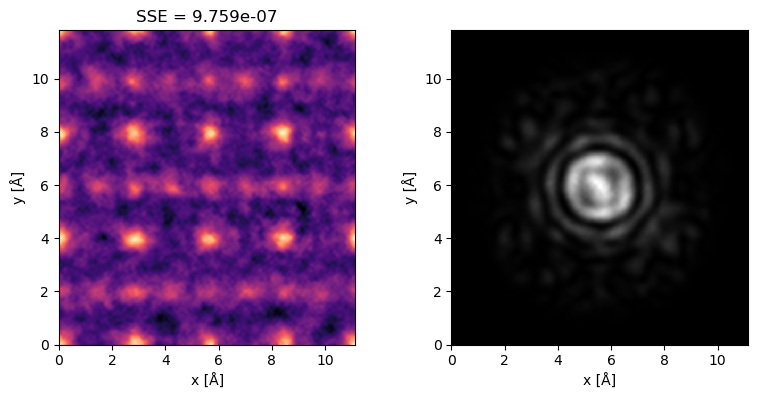

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
mxrpie_objects[-1].angle().interpolate(electrostatic_potential.sampling).show(
    ax=ax1, cmap="magma", title=f"SSE = {float(mxrpie_sse[-1]):.3e}"
)
mxrpie_probes[-1][0].intensity().interpolate(electrostatic_potential.sampling).show(
    ax=ax2
)
fig.tight_layout()

This is indeed quite poor - let's see how much better the Mixed-State PIE algorithm performs:

In [7]:
mixed_states_ptycho_operator_02 = MixedStatePtychographicOperator(
    pixelated_measurement_incoherent,
    energy=200e3,
    semiangle_cutoff=24,
    num_probes=2,
    device="gpu",
    defocus=75,
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    mixpie_objects,
    mixpie_probes,
    mixpie_positions,
    mixpie_sse,
) = mixed_states_ptycho_operator_02.reconstruct(
    max_iterations=10,
    random_seed=1,
    verbose=True,
    warmup_update_steps=mixed_states_ptycho_operator._num_diffraction_patterns * 1,
    return_iterations=True,
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 483 steps
--Mixed-State PIE for 4347 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.131e-06
----Iteration 1 , SSE = 8.109e-07
----Iteration 2 , SSE = 6.589e-07
----Iteration 3 , SSE = 5.984e-07
----Iteration 4 , SSE = 5.818e-07
----Iteration 5 , SSE = 5.745e-07
----Iteration 6 , SSE = 5.714e-07
----Iteration 7 , SSE = 5.712e-07
----Iteration 8 , SSE = 5.648e-07
----Iteration 9 , SSE = 5.649e-07


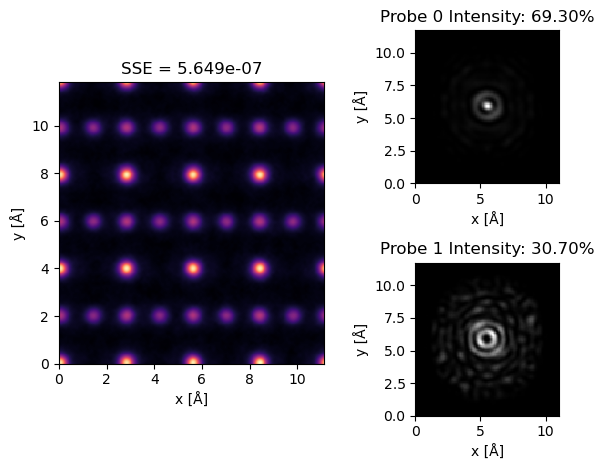

In [8]:
probe_intensity_ratios = np.sum(
    [probe.intensity().array for probe in mixpie_probes[-1]], axis=(-2, -1)
)
probe_intensity_ratios /= np.sum(probe_intensity_ratios) / 100

fig, axd = plt.subplot_mosaic(
    [["left", "top-right"], ["left", "bottom-right"]], constrained_layout=True
)
mixpie_objects[-1].angle().interpolate(electrostatic_potential.sampling).show(
    ax=axd["left"], title=f"SSE = {float(mixpie_sse[-1]):.3e}", cmap="magma"
)
mixpie_probes[-1][0].intensity().show(
    ax=axd["top-right"], title=f"Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%"
)
mixpie_probes[-1][1].intensity().show(
    ax=axd["bottom-right"], title=f"Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%"
)
fig.tight_layout()

Even though this is considerably better - the reconstructed probes don't have the same intensity ratios as the simulation (or in-fact dumbell shape for the second probe).  
We can do even better by using the second keyword parameter in `reconstruct()`, to orthogonalize our probes (with some frequency. here set to each update step but this is less important)

In [9]:
mixed_states_ptycho_operator_03 = MixedStatePtychographicOperator(
    pixelated_measurement_incoherent,
    energy=200e3,
    semiangle_cutoff=24,
    num_probes=2,
    device="gpu",
    defocus=75,
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    mixpie_objects_02,
    mixpie_probes_02,
    mixpie_positions_02,
    mixpie_sse_02,
) = mixed_states_ptycho_operator_03.reconstruct(
    max_iterations=10,
    random_seed=1,
    verbose=True,
    probe_orthogonalization_frequency=1,
    warmup_update_steps=mixed_states_ptycho_operator._num_diffraction_patterns * 1,
    return_iterations=True,
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 483 steps
--Mixed-State PIE for 4347 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.131e-06
----Iteration 1 , SSE = 8.052e-07
----Iteration 2 , SSE = 6.509e-07
----Iteration 3 , SSE = 5.931e-07
----Iteration 4 , SSE = 5.800e-07
----Iteration 5 , SSE = 5.736e-07
----Iteration 6 , SSE = 5.701e-07
----Iteration 7 , SSE = 5.698e-07
----Iteration 8 , SSE = 5.638e-07
----Iteration 9 , SSE = 5.646e-07


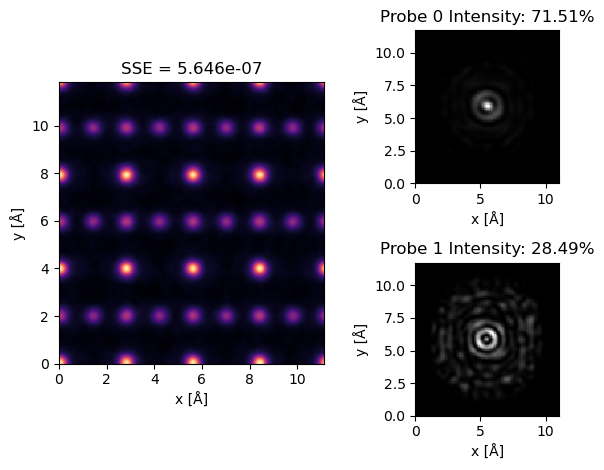

In [10]:
probe_intensity_ratios = np.sum(
    [probe.intensity().array for probe in mixpie_probes_02[-1]], axis=(-2, -1)
)
probe_intensity_ratios /= np.sum(probe_intensity_ratios) / 100

fig, axd = plt.subplot_mosaic(
    [["left", "top-right"], ["left", "bottom-right"]], constrained_layout=True
)
mixpie_objects_02[-1].angle().interpolate(electrostatic_potential.sampling).show(
    ax=axd["left"], title=f"SSE = {float(mixpie_sse_02[-1]):.3e}", cmap="magma"
)
mixpie_probes_02[-1][0].intensity().show(
    ax=axd["top-right"], title=f"Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%"
)
mixpie_probes_02[-1][1].intensity().show(
    ax=axd["bottom-right"], title=f"Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%"
)
fig.tight_layout()

Indeed, our reconstructed probes have almost precisely the simulated ratios and shape!